In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [26]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [27]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(42) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y", start="2018-01-01", end="2020-12-31")
    US10_stocks_prices[stock] = historical_data

In [28]:
US10_Stocks

['SCHW', 'JNJ', 'AMZN', 'ETN', 'LIN', 'PFE', 'BAC', 'PG', 'JPM', 'GILD']

利用股價生成日報酬

In [29]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [30]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [31]:
pd.DataFrame(US10_stocks_returns)

,SCHW,JNJ,AMZN,ETN,LIN,PFE,BAC,PG,JPM,GILD
0,0.001555,0.009553,0.012775,0.035252,0.008387,0.007410,-0.003345,-0.001214,0.001019,0.007557
1,0.005629,-0.000071,0.004476,-0.010657,0.015683,0.002179,0.013087,0.007069,0.014326,-0.010179
2,0.003860,0.008254,0.016163,0.007676,0.008751,0.001903,0.004637,0.000658,-0.006420,0.008390
3,0.004423,0.001270,0.014425,0.007864,-0.000372,-0.011123,-0.006924,0.005261,0.001477,-0.001611
4,0.021056,0.015857,0.004676,-0.000610,0.009733,-0.001097,0.004980,-0.007305,0.005069,0.049731
...,...,...,...,...,...,...,...,...,...,...
749,0.013749,-0.005107,-0.006627,0.003516,0.006470,0.019053,0.028757,-0.001538,0.027944,0.006667
750,-0.005540,0.003488,-0.003949,0.008973,0.005959,-0.004541,-0.002995,0.010122,-0.004398,-0.005403
751,0.016903,0.004722,0.035071,-0.002964,0.013249,-0.012074,0.005674,0.006971,0.006585,-0.003154
752,-0.007556,0.006201,0.011584,-0.004757,-0.002307,0.006246,-0.003983,-0.001875,-0.002633,-0.001055


計算統計數字

In [32]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

SCHW    0.063778
JNJ     0.215838
AMZN    1.763517
ETN     0.629478
LIN     0.773736
PFE     0.188138
BAC     0.072348
PG      0.657567
JPM     0.269457
GILD   -0.147648
dtype: float64

In [33]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,SCHW,JNJ,AMZN,ETN,LIN,PFE,BAC,PG,JPM,GILD
SCHW,0.000593,0.000159,0.000171,0.000355,0.000243,0.000167,0.000473,0.000132,0.000419,0.000142
JNJ,0.000159,0.000221,0.000108,0.000171,0.000150,0.000153,0.000176,0.000137,0.000162,0.000122
AMZN,0.000171,0.000108,0.000438,0.000156,0.000151,0.000117,0.000179,0.000103,0.000151,0.000135
ETN,0.000355,0.000171,0.000156,0.000487,0.000274,0.000173,0.000415,0.000152,0.000373,0.000146
LIN,0.000243,0.000150,0.000151,0.000274,0.000331,0.000150,0.000286,0.000133,0.000268,0.000120
PFE,0.000167,0.000153,0.000117,0.000173,0.000150,0.000269,0.000198,0.000124,0.000185,0.000143
BAC,0.000473,0.000176,0.000179,0.000415,0.000286,0.000198,0.000608,0.000157,0.000520,0.000167
PG,0.000132,0.000137,0.000103,0.000152,0.000133,0.000124,0.000157,0.000225,0.000143,0.000105
JPM,0.000419,0.000162,0.000151,0.000373,0.000268,0.000185,0.000520,0.000143,0.000503,0.000139
GILD,0.000142,0.000122,0.000135,0.000146,0.000120,0.000143,0.000167,0.000105,0.000139,0.000344


In [34]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 100000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((10,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(US10_Stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [35]:
# SAMPLE：隨機投資組合

results = np.zeros((10,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(US10_Stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 SCHW    0.063778
JNJ     0.215838
AMZN    1.763517
ETN     0.629478
LIN     0.773736
PFE     0.188138
BAC     0.072348
PG      0.657567
JPM     0.269457
GILD   -0.147648
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.14267429 0.14980327 0.15516694 0.15718551 0.06642307 0.02244461
 0.09451047 0.12874017 0.04049621 0.04255546]
----------------------------------------------------------------------------------------------------
報酬率： 0.5657554652350104
----------------------------------------------------------------------------------------------------
標準差： 0.014913293938763476
----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


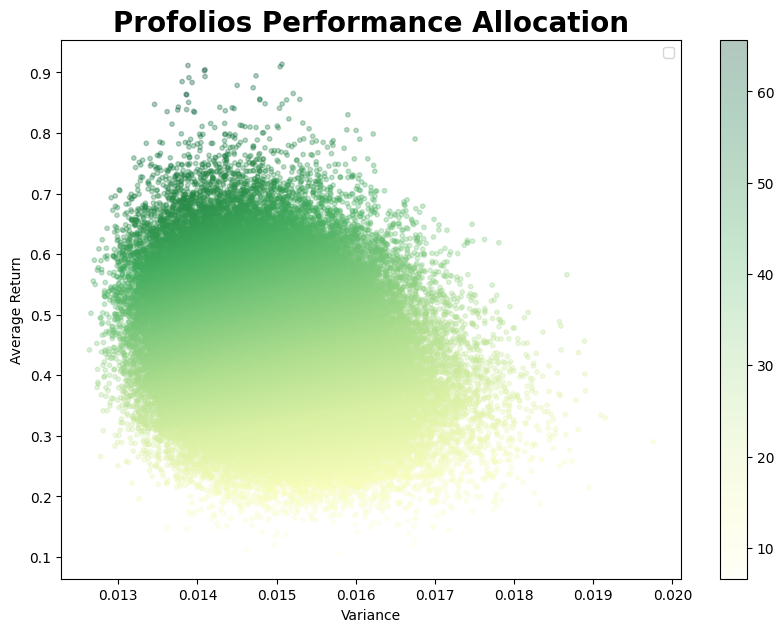

In [36]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [37]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

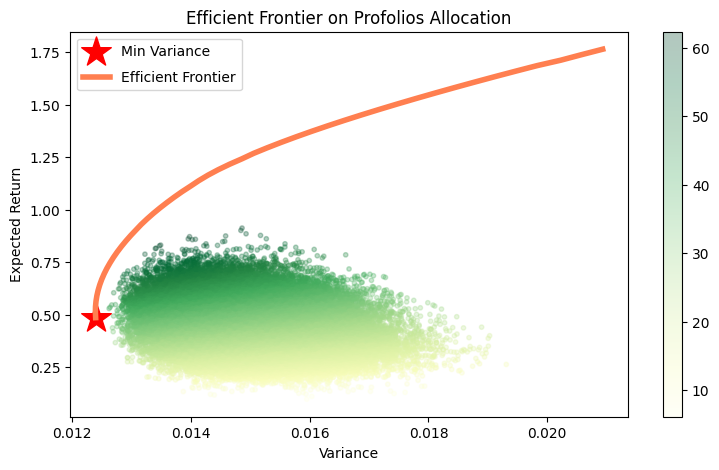

In [38]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)

切線法

In [39]:
# f = mean_returns.values

# #建立不同的無風險利率(-1 ~ 1)
# Rfs = np.linspace(-1, 1, 1000)

# weights = []
# for Rf in Rfs:
#     Rf = np.full((f.shape[0], 1), Rf)
#     f = f.reshape(10, 1)
#     Rbar = f + Rf
#     V = cov_matrix.values
#     V_inv = np.linalg.inv(V)
#     V_inv_Rbar = np.dot(V_inv, Rbar)

#     # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
#     ones_vector = np.ones((10, 1))
#     V_inv_ones = np.dot(V_inv, ones_vector)

#     # 計算 Rf * (V^(-1) * 1)
#     Rf_V_inv_ones = Rf * V_inv_ones
#     Z = V_inv_Rbar - Rf_V_inv_ones

#     # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
#     Z_transpose = Z.T
#     Z_dot_ones = np.dot(Z_transpose, ones_vector)

#     # 最後計算 X
#     X = V_inv_Rbar - Rf_V_inv_ones / Z_dot_ones
#     weights.append(X)


# vars = []
# fp = []
# for weight in weights:
#     var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
#     vars.append(float(var))
#     fp.append(float(np.dot(weight.T, f)))

# plt.title('Efficient Frontier - Method 1')
# plt.plot(vars, fp)


另一種切線法?

C:\Users\USER\AppData\Local\Temp\ipykernel_9252\3299991111.py:37: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = opt.minimize(get_Varp, init_h, method='SLSQP', bounds=bound, constraints=conditions)


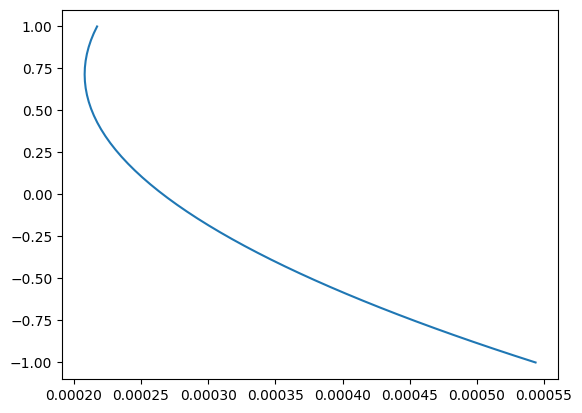

In [42]:
f = mean_returns.values

#定義取得fp及Varp的函數
def get_fp(h):
    return np.dot(h.T, f)

def get_Varp(h):
    return np.dot(np.dot(h.T, cov_matrix.values), h)

#引入規劃求解套件
import scipy.optimize as opt


#定義限制式1，h的總和要為1
def constraint1(h):
    return np.sum(h) - 1

#定義限制式2，fp要等於我們設定的目標報酬率(即Rf)
def constraint2(h):
    return get_fp(h) - Rf

#設定h的權重要在-1~1之間
bound = tuple((-1,1) for _ in range(f.shape[0]))


#將兩個限制式打包成一個tuple
conditions = ({'type':'eq', 'fun':constraint1}, 
              {'type':'eq', 'fun':constraint2})

#隨便給一個求解的起始值(每個都先給0.1)
init_h = np.full((f.shape[0], 1), 1/f.shape[0])

#先設定Rf範圍，再各別求最佳解
Rfs = np.linspace(-1, 1, 50)
t_weights = []
for idx, Rf in enumerate(Rfs):
    result = opt.minimize(get_Varp, init_h, method='SLSQP', bounds=bound, constraints=conditions)
    t_weights.append(result.x)

plt.plot([get_Varp(h) for h in t_weights], [get_fp(h) for h in t_weights])


切火腿法

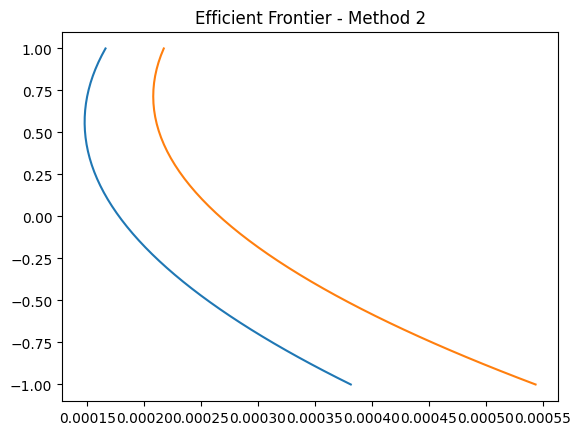

In [43]:
f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率
Rfs = np.linspace(-1, 1, 50)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - (u * B)) / D
    _gamma = ((A * u) - B) / D
    h = (_lambda * V_inv @ e) + (_gamma * V_inv @ f)
    weights.append(h)

hC = (np.linalg.inv(cov_matrix.values) @ e) / (e.T @ np.linalg.inv(cov_matrix.values) @ e)
hQ = (np.linalg.inv(cov_matrix.values) @ f) / (f.T @ np.linalg.inv(cov_matrix.values) @ e)

hC_point = (np.dot(hC.T, cov_matrix.values) @ hC, np.dot(hC.T, f))
hQ_point = (np.dot(hQ.T, cov_matrix.values) @ hQ, np.dot(hQ.T, f))

vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

fig, ax = plt.subplots()
plt.title('Efficient Frontier - Method 2')
# plt.scatter(*hC_point, c='red', s=10)
# plt.annotate('hC', xy=hC_point)
# plt.scatter(*hQ_point, c='green', s=10, label='QML')
# plt.annotate('hQ', xy=hQ_point)
plt.plot(vars, fp)

plt.plot([get_Varp(h) for h in t_weights], [get_fp(h) for h in t_weights])